# Credit Scoring Model - German Credit Data Analysis

This notebook performs comprehensive analysis and builds credit scoring models using the German Credit dataset.

## Dataset Overview
- **Source**: German Credit Dataset (UCI Machine Learning Repository)
- **Records**: 1000 credit applications
- **Features**: 20 attributes (mix of categorical and numerical)
- **Target**: Credit risk (1 = Good, 2 = Bad)

## Objectives
1. Exploratory Data Analysis
2. Data Preprocessing
3. Model Building (Logistic Regression, Random Forest, XGBoost)
4. Model Evaluation and Comparison
5. Credit Score Generation and Risk Assessment

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, accuracy_score,
    precision_score, recall_score
)

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Helper functions for credit scoring metrics
def calculate_gini(y_true, y_proba):
    """Calculate Gini coefficient from ROC-AUC"""
    auc = roc_auc_score(y_true, y_proba)
    gini = 2 * auc - 1
    return gini

def calculate_ks_statistic(y_true, y_proba):
    """Calculate Kolmogorov-Smirnov statistic"""
    # Get ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    # KS is the maximum difference between TPR and FPR
    ks = np.max(tpr - fpr)
    return ks

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Define feature names for the German Credit dataset
feature_names = [
    'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_status', 'employment', 'installment_rate', 'personal_status',
    'other_parties', 'residence_since', 'property_magnitude', 'age',
    'other_payment_plans', 'housing', 'existing_credits', 'job',
    'num_dependents', 'own_telephone', 'foreign_worker', 'class'
]

# Load the data
data_path = 'german_credit_data/german.data'
df = pd.read_csv(data_path, sep=' ', header=None, names=feature_names)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1000, 21)

First few rows:


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_rate,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [3]:
# Basic info
print("Dataset Information:")
print("=" * 50)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   checking_status      1000 non-null   object
 1   duration             1000 non-null   int64 
 2   credit_history       1000 non-null   object
 3   purpose              1000 non-null   object
 4   credit_amount        1000 non-null   int64 
 5   savings_status       1000 non-null   object
 6   employment           1000 non-null   object
 7   installment_rate     1000 non-null   int64 
 8   personal_status      1000 non-null   object
 9   other_parties        1000 non-null   object
 10  residence_since      1000 non-null   int64 
 11  property_magnitude   1000 non-null   object
 12  age                  1000 non-null   int64 
 13  other_payment_plans  1000 non-null   object
 14  housing              1000 non-null   object
 15  existing_credits     1000 non-null 

In [4]:
# Check target distribution
print("\nTarget Variable Distribution:")
print("=" * 50)
print(df['class'].value_counts())
print(f"\nClass proportions:")
print(df['class'].value_counts(normalize=True))


Target Variable Distribution:
class
1    700
2    300
Name: count, dtype: int64

Class proportions:
class
1    0.7
2    0.3
Name: proportion, dtype: float64


## 3. Exploratory Data Analysis (EDA)

In [5]:
# Statistical summary
df.describe()

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,num_dependents,class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [6]:
# Check for missing values
print("Missing Values:")
print("=" * 50)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found!")
else:
    print(missing[missing > 0])

Missing Values:
No missing values found!


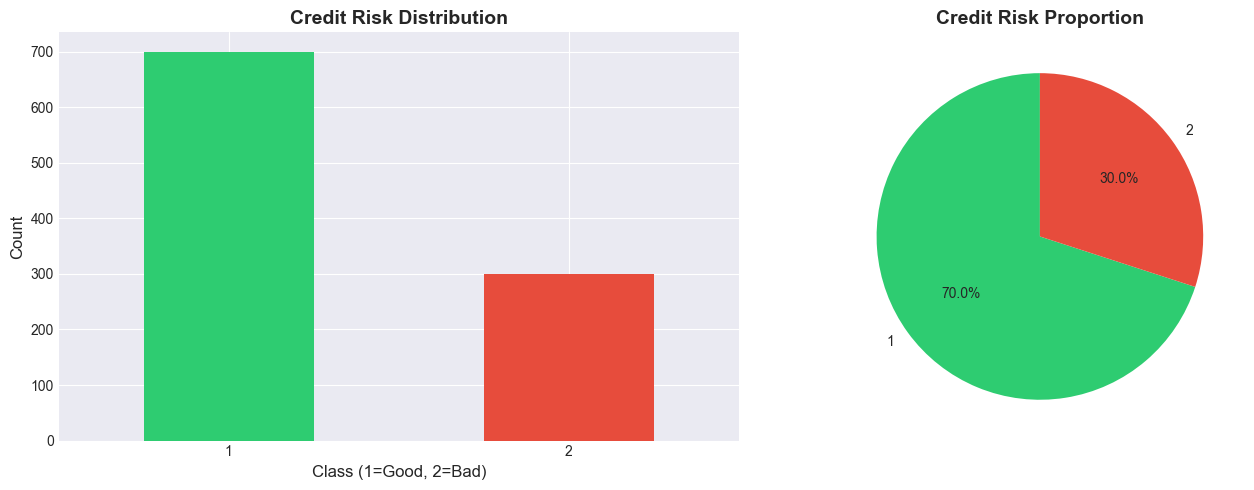

In [7]:
# Visualize target distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
df['class'].value_counts().plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Credit Risk Distribution', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Class (1=Good, 2=Bad)', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].tick_params(rotation=0)

# Pie chart
df['class'].value_counts().plot(kind='pie', ax=ax[1], autopct='%1.1f%%', 
                                 colors=['#2ecc71', '#e74c3c'], startangle=90)
ax[1].set_title('Credit Risk Proportion', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [8]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('class')  # Remove target variable

print(f"Numeric features: {numeric_cols}")
print(f"\nNumber of numeric features: {len(numeric_cols)}")

Numeric features: ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']

Number of numeric features: 7


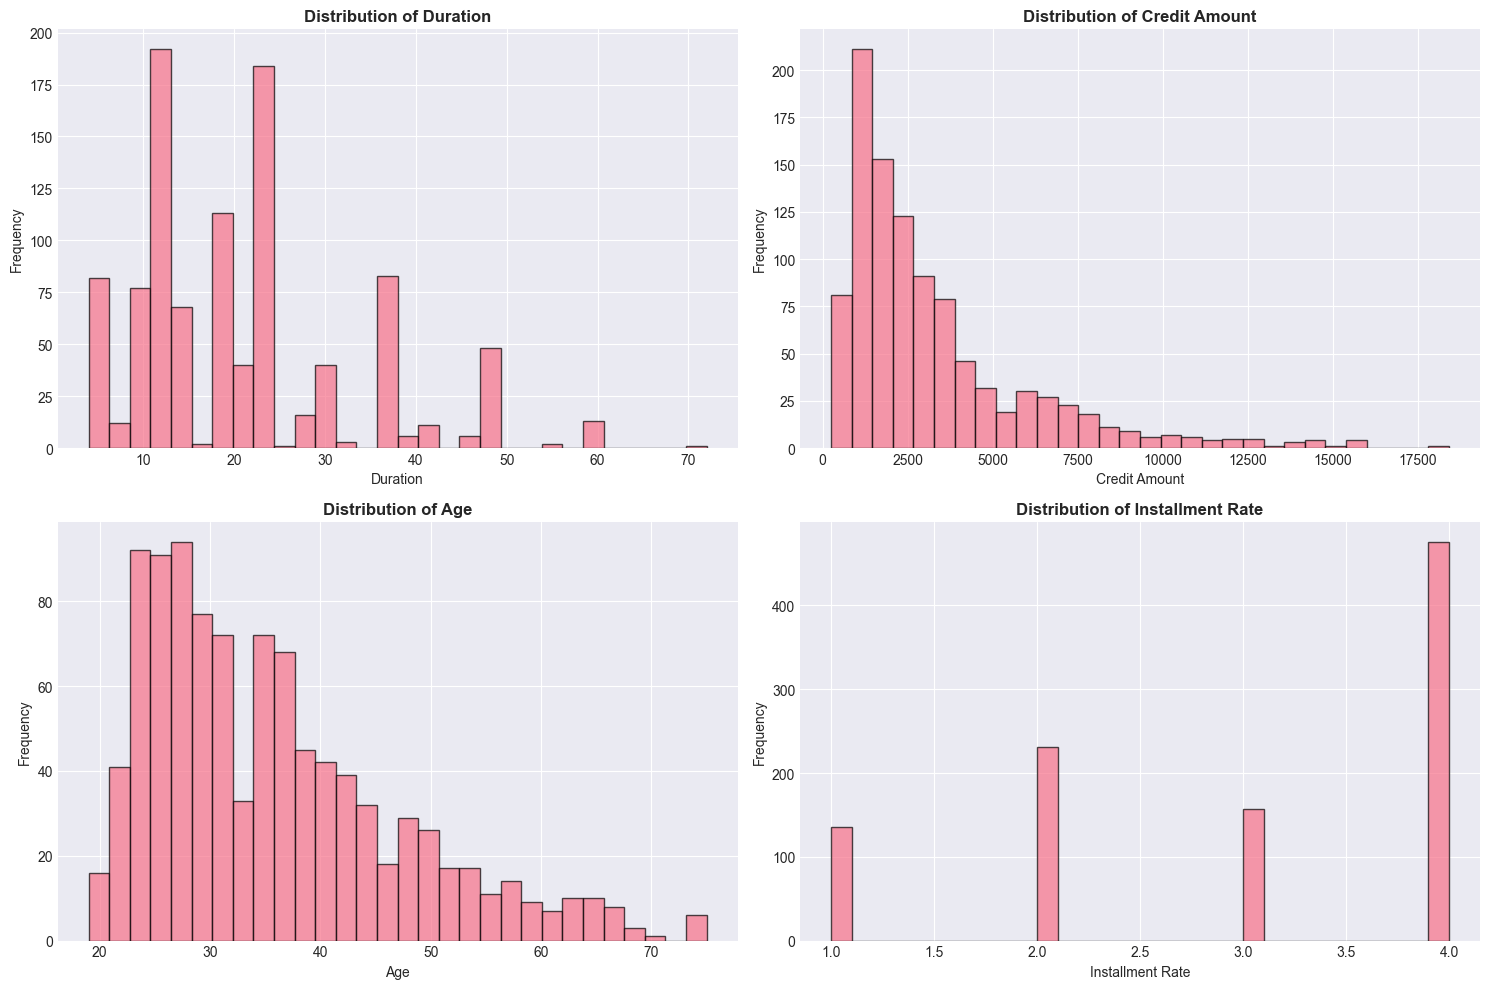

In [9]:
# Distribution of key numeric features
key_features = ['duration', 'credit_amount', 'age', 'installment_rate']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    if col in df.columns:
        axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col.replace('_', ' ').title())
        axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

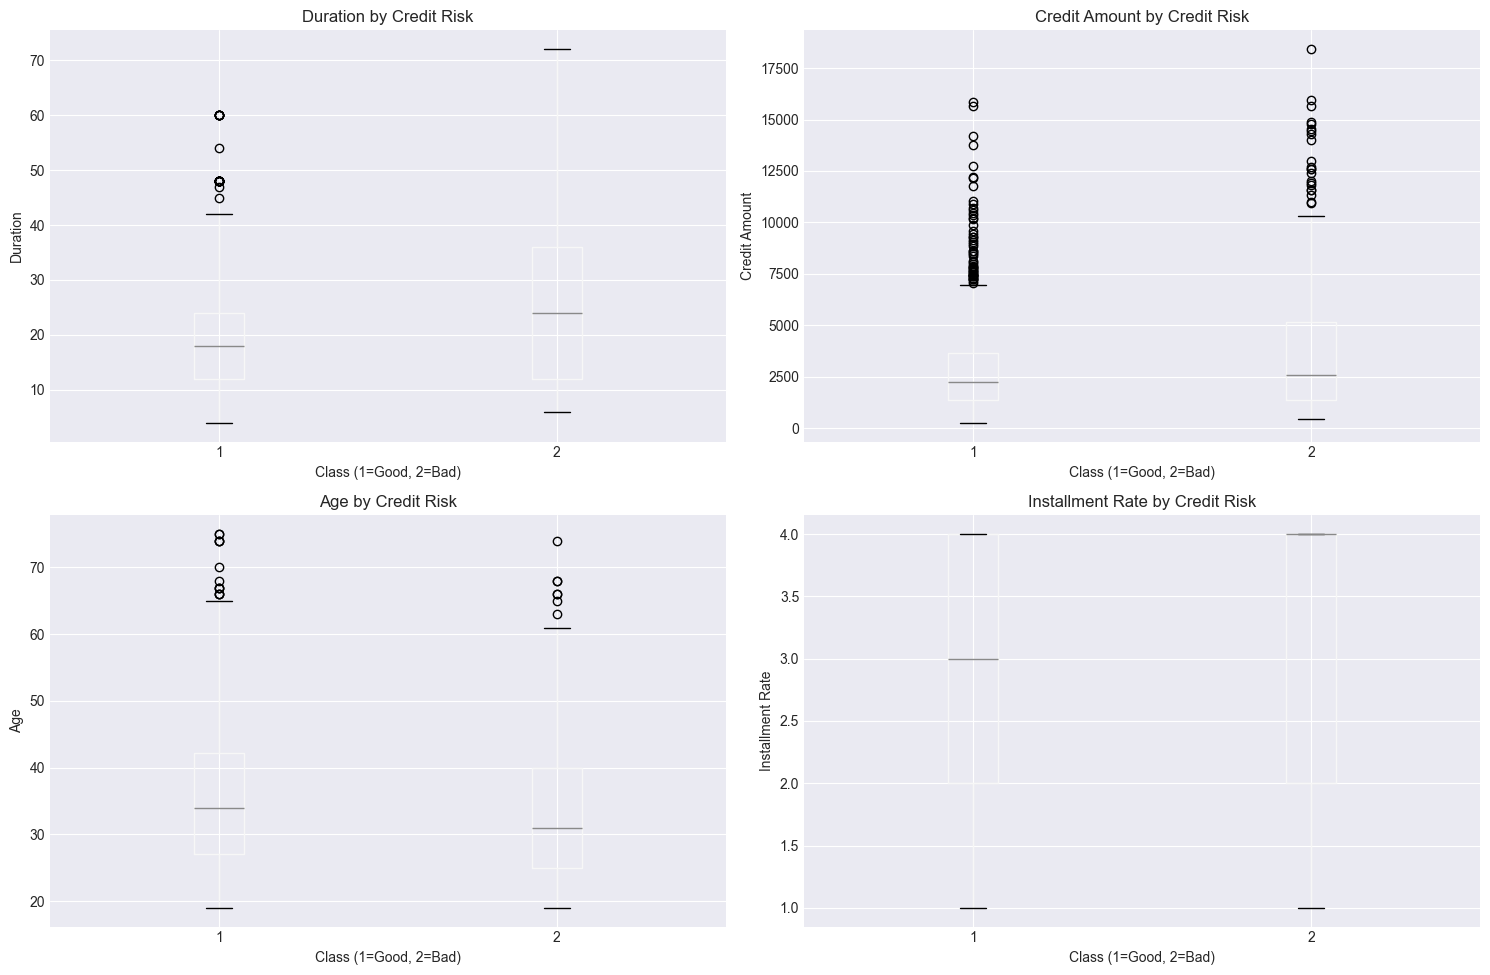

In [10]:
# Box plots for numeric features by class
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(key_features):
    if col in df.columns:
        df.boxplot(column=col, by='class', ax=axes[idx])
        axes[idx].set_title(f'{col.replace("_", " ").title()} by Credit Risk')
        axes[idx].set_xlabel('Class (1=Good, 2=Bad)')
        axes[idx].set_ylabel(col.replace('_', ' ').title())

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

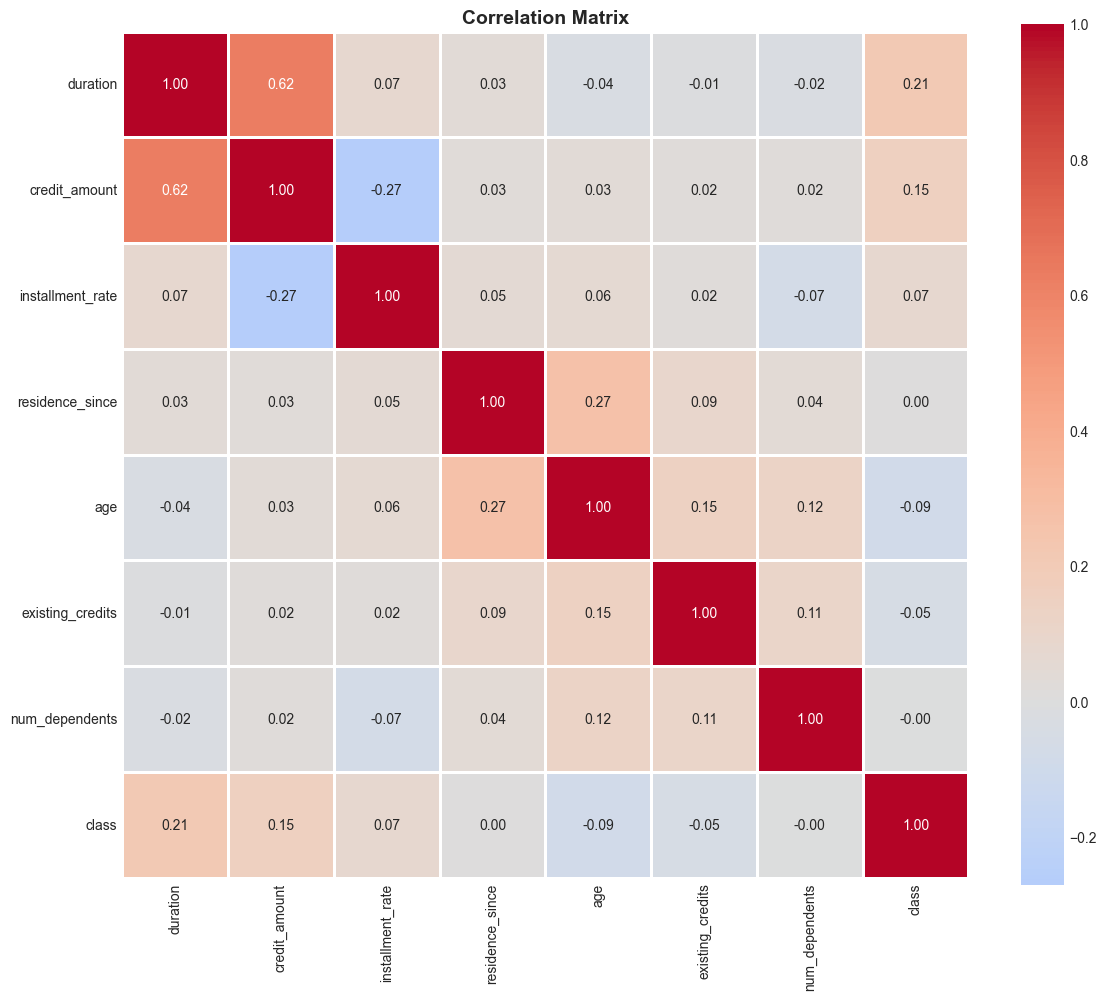

In [11]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols + ['class']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [12]:
# Create a copy for processing
df_processed = df.copy()

# Convert target to binary (1=Good -> 0, 2=Bad -> 1)
df_processed['class'] = df_processed['class'].map({1: 0, 2: 1})

print("Target variable recoded:")
print("0 = Good Credit (Low Risk)")
print("1 = Bad Credit (High Risk)")
print(f"\nNew distribution:\n{df_processed['class'].value_counts()}")

Target variable recoded:
0 = Good Credit (Low Risk)
1 = Bad Credit (High Risk)

New distribution:
class
0    700
1    300
Name: count, dtype: int64


In [13]:
# Encode categorical variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

print(f"Categorical features to encode: {categorical_cols}")

# Use one-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"\nShape after encoding: {df_encoded.shape}")
print(f"Number of features: {df_encoded.shape[1] - 1}")  # Exclude target

Categorical features to encode: ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']

Shape after encoding: (1000, 49)
Number of features: 48


In [14]:
# Separate features and target
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts())

Features shape: (1000, 48)
Target shape: (1000,)

Target distribution:
class
0    700
1    300
Name: count, dtype: int64


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 800
Test set size: 200

Training set class distribution:
class
0    560
1    240
Name: count, dtype: int64

Test set class distribution:
class
0    140
1     60
Name: count, dtype: int64


In [16]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"\nScaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

Features scaled successfully!

Scaled training data shape: (800, 48)
Scaled test data shape: (200, 48)


## 5. Model Building

### 5.1 Logistic Regression

In [17]:
# Train Logistic Regression
lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)
lr_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Logistic Regression Performance:")
print("=" * 50)
print(f"Training Accuracy: {accuracy_score(y_train, lr_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, lr_test_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, lr_test_proba):.4f}")
print(f"Test F1-Score: {f1_score(y_test, lr_test_pred):.4f}")

Logistic Regression Performance:
Training Accuracy: 0.7825
Test Accuracy: 0.7850
Test ROC-AUC: 0.8000
Test F1-Score: 0.6195


### 5.2 Random Forest

In [18]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=RANDOM_STATE,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10
)
rf_model.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Random Forest Performance:")
print("=" * 50)
print(f"Training Accuracy: {accuracy_score(y_train, rf_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, rf_test_pred):.4f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, rf_test_proba):.4f}")
print(f"Test F1-Score: {f1_score(y_test, rf_test_pred):.4f}")

Random Forest Performance:
Training Accuracy: 0.7750
Test Accuracy: 0.7250
Test ROC-AUC: 0.7764
Test F1-Score: 0.2466


### 5.3 XGBoost

In [19]:
if XGBOOST_AVAILABLE:
    # Train XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_test_pred = xgb_model.predict(X_test)
    xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    # Evaluate
    print("XGBoost Performance:")
    print("=" * 50)
    print(f"Training Accuracy: {accuracy_score(y_train, xgb_train_pred):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, xgb_test_pred):.4f}")
    print(f"Test ROC-AUC: {roc_auc_score(y_test, xgb_test_proba):.4f}")
    print(f"Test F1-Score: {f1_score(y_test, xgb_test_pred):.4f}")
else:
    print("XGBoost not available. Skipping...")

XGBoost Performance:
Training Accuracy: 0.9637
Test Accuracy: 0.7450
Test ROC-AUC: 0.7936
Test F1-Score: 0.5321


## 6. Model Evaluation and Comparison

In [20]:
# Compare models with comprehensive metrics
models_results = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, lr_test_pred),
        'Precision': precision_score(y_test, lr_test_pred),
        'Recall': recall_score(y_test, lr_test_pred),
        'F1-Score': f1_score(y_test, lr_test_pred),
        'ROC-AUC': roc_auc_score(y_test, lr_test_proba),
        'Gini': calculate_gini(y_test, lr_test_proba),
        'KS-Statistic': calculate_ks_statistic(y_test, lr_test_proba)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, rf_test_pred),
        'Precision': precision_score(y_test, rf_test_pred),
        'Recall': recall_score(y_test, rf_test_pred),
        'F1-Score': f1_score(y_test, rf_test_pred),
        'ROC-AUC': roc_auc_score(y_test, rf_test_proba),
        'Gini': calculate_gini(y_test, rf_test_proba),
        'KS-Statistic': calculate_ks_statistic(y_test, rf_test_proba)
    }
}

if XGBOOST_AVAILABLE:
    models_results['XGBoost'] = {
        'Accuracy': accuracy_score(y_test, xgb_test_pred),
        'Precision': precision_score(y_test, xgb_test_pred),
        'Recall': recall_score(y_test, xgb_test_pred),
        'F1-Score': f1_score(y_test, xgb_test_pred),
        'ROC-AUC': roc_auc_score(y_test, xgb_test_proba),
        'Gini': calculate_gini(y_test, xgb_test_proba),
        'KS-Statistic': calculate_ks_statistic(y_test, xgb_test_proba)
    }

results_df = pd.DataFrame(models_results).T

print("Model Comparison - Comprehensive Metrics:")
print("=" * 80)
print(results_df.round(4))

print("\n" + "=" * 80)
print("Metric Explanations:")
print("-" * 80)
print("Accuracy:      Overall correctness of predictions")
print("Precision:     Of predicted defaults, how many are actually defaults")
print("Recall:        Of actual defaults, how many are correctly identified")
print("F1-Score:      Harmonic mean of Precision and Recall")
print("ROC-AUC:       Area Under ROC Curve (discrimination ability)")
print("Gini:          Gini coefficient (2*AUC - 1), ranges from -1 to 1")
print("KS-Statistic:  Kolmogorov-Smirnov test (max separation between classes)")
print("=" * 80)

Model Comparison - Comprehensive Metrics:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC    Gini  \
Logistic Regression     0.785     0.6604  0.5833    0.6195   0.8000  0.6000   
Random Forest           0.725     0.6923  0.1500    0.2466   0.7764  0.5529   
XGBoost                 0.745     0.5918  0.4833    0.5321   0.7936  0.5871   

                     KS-Statistic  
Logistic Regression        0.5524  
Random Forest              0.4262  
XGBoost                    0.4952  

Metric Explanations:
--------------------------------------------------------------------------------
Accuracy:      Overall correctness of predictions
Precision:     Of predicted defaults, how many are actually defaults
Recall:        Of actual defaults, how many are correctly identified
F1-Score:      Harmonic mean of Precision and Recall
ROC-AUC:       Area Under ROC Curve (discrimination ability)
Gini:          Gini coefficient (2*AUC - 1), ranges from -1 to 1
KS-Statistic:  Kolmogorov-S

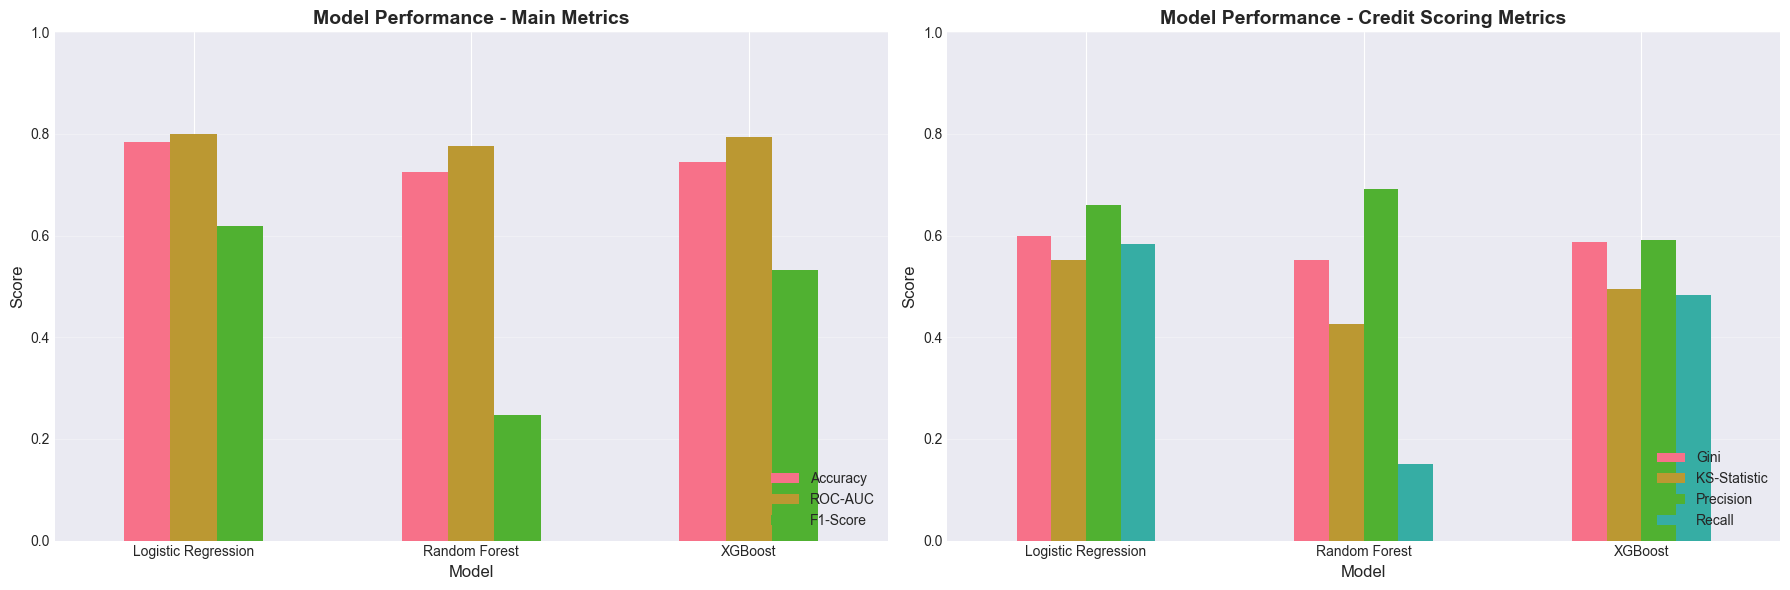

In [21]:
# Visualize model comparison with all metrics
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Main metrics (Accuracy, ROC-AUC, F1-Score)
main_metrics = results_df[['Accuracy', 'ROC-AUC', 'F1-Score']]
main_metrics.plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Model Performance - Main Metrics', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Credit scoring metrics (Gini, KS-Statistic, Precision, Recall)
credit_metrics = results_df[['Gini', 'KS-Statistic', 'Precision', 'Recall']]
credit_metrics.plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Model Performance - Credit Scoring Metrics', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

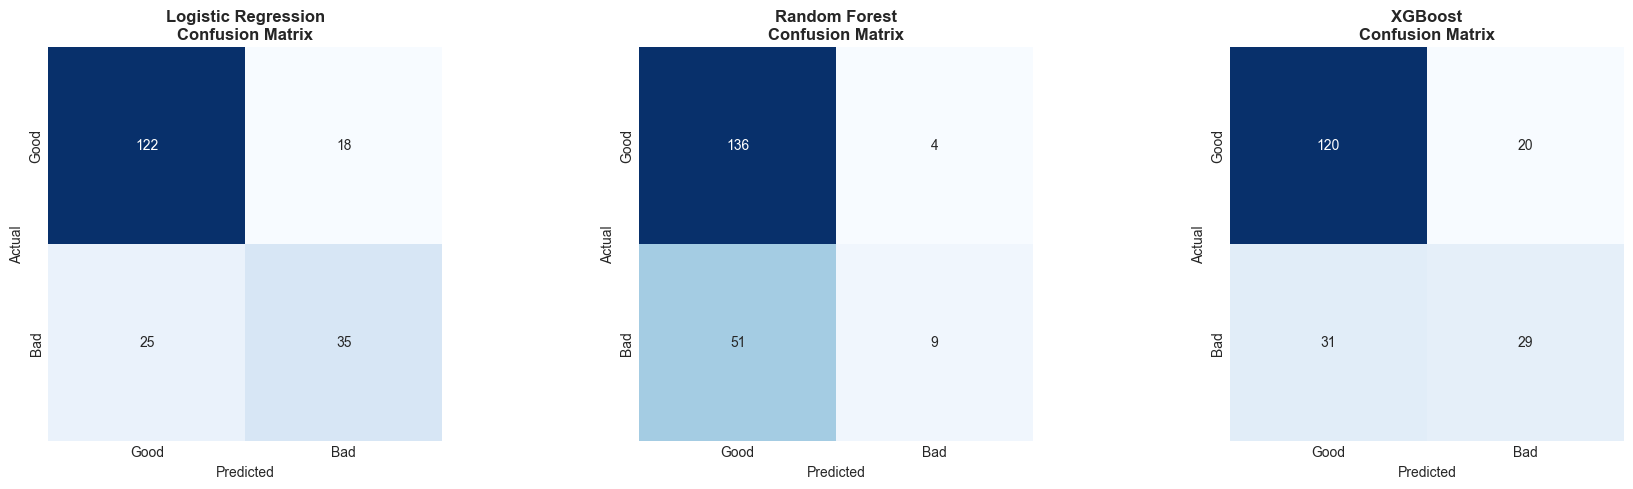

In [22]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Logistic Regression', lr_test_pred),
    ('Random Forest', rf_test_pred),
]

if XGBOOST_AVAILABLE:
    models.append(('XGBoost', xgb_test_pred))

for idx, (name, pred) in enumerate(models):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar=False, square=True)
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_xticklabels(['Good', 'Bad'])
    axes[idx].set_yticklabels(['Good', 'Bad'])

plt.tight_layout()
plt.show()

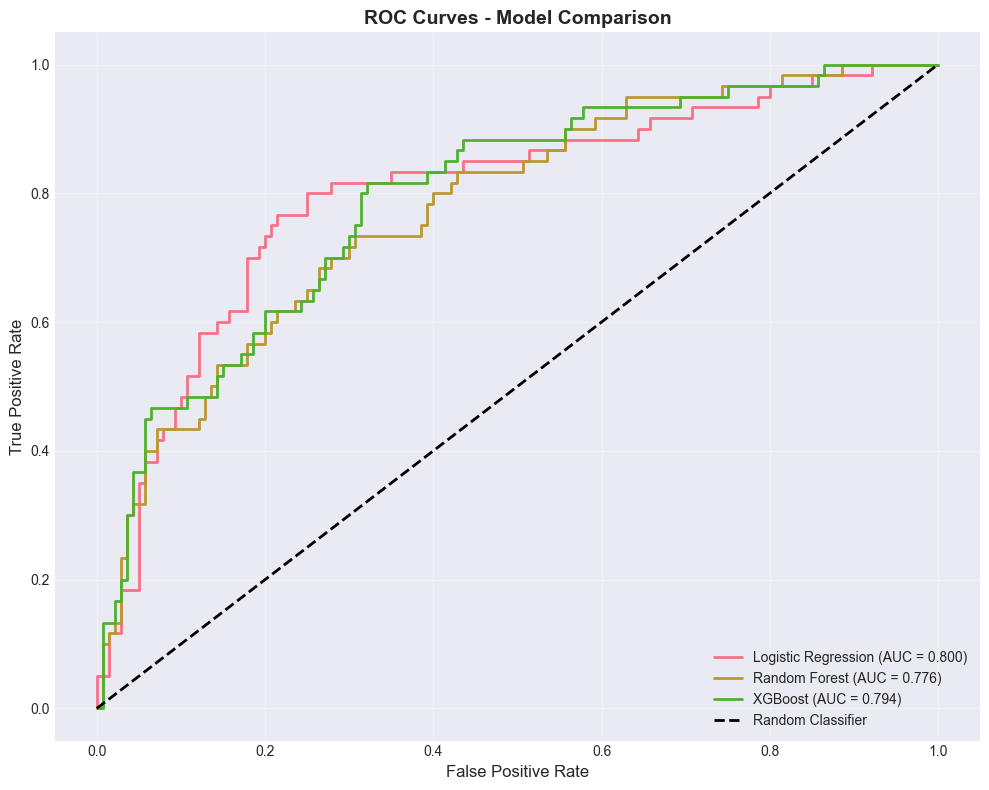

In [23]:
# ROC Curves
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_test_proba)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr_test_proba):.3f})', 
         linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_proba)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_test_proba):.3f})', 
         linewidth=2)

# XGBoost
if XGBOOST_AVAILABLE:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_test_proba)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_test_proba):.3f})', 
             linewidth=2)

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Kolmogorov-Smirnov (KS) Statistic Visualization


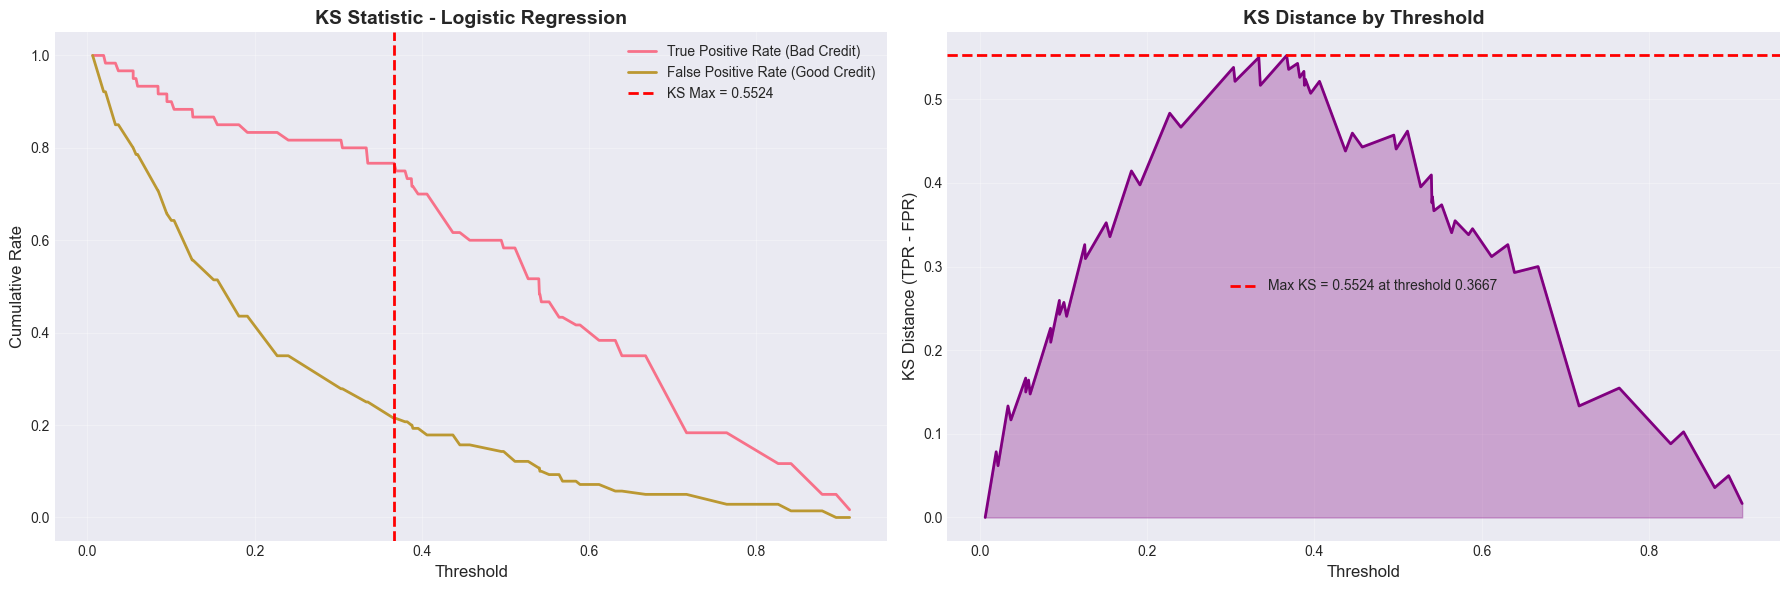


Best Model: Logistic Regression
KS Statistic: 0.5524
Optimal Threshold: 0.3667

Interpretation:
- KS > 0.4: Excellent model separation
- KS 0.3-0.4: Good model separation
- KS 0.2-0.3: Fair model separation
- KS < 0.2: Poor model separation


In [24]:
# KS Statistic Visualization - Best Model
print("Kolmogorov-Smirnov (KS) Statistic Visualization")
print("=" * 80)

# Use best model based on ROC-AUC
best_model_idx = results_df['ROC-AUC'].idxmax()
if best_model_idx == 'Logistic Regression':
    best_proba_ks = lr_test_proba
elif best_model_idx == 'Random Forest':
    best_proba_ks = rf_test_proba
else:
    best_proba_ks = xgb_test_proba

# Calculate cumulative distribution for each class
fpr, tpr, thresholds = roc_curve(y_test, best_proba_ks)
ks_stat = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# KS Plot - Cumulative distributions
axes[0].plot(thresholds, tpr, label='True Positive Rate (Bad Credit)', linewidth=2)
axes[0].plot(thresholds, fpr, label='False Positive Rate (Good Credit)', linewidth=2)
axes[0].axvline(thresholds[ks_idx], color='red', linestyle='--', linewidth=2, 
                label=f'KS Max = {ks_stat:.4f}')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Cumulative Rate', fontsize=12)
axes[0].set_title(f'KS Statistic - {best_model_idx}', fontsize=14, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# KS Distance Plot
ks_distance = tpr - fpr
axes[1].plot(thresholds, ks_distance, linewidth=2, color='purple')
axes[1].axhline(ks_stat, color='red', linestyle='--', linewidth=2, 
                label=f'Max KS = {ks_stat:.4f} at threshold {thresholds[ks_idx]:.4f}')
axes[1].fill_between(thresholds, 0, ks_distance, alpha=0.3, color='purple')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('KS Distance (TPR - FPR)', fontsize=12)
axes[1].set_title('KS Distance by Threshold', fontsize=14, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_model_idx}")
print(f"KS Statistic: {ks_stat:.4f}")
print(f"Optimal Threshold: {thresholds[ks_idx]:.4f}")
print("\nInterpretation:")
print("- KS > 0.4: Excellent model separation")
print("- KS 0.3-0.4: Good model separation")
print("- KS 0.2-0.3: Fair model separation")
print("- KS < 0.2: Poor model separation")
print("=" * 80)

In [25]:
# Classification reports
print("Logistic Regression Classification Report:")
print("=" * 70)
print(classification_report(y_test, lr_test_pred, target_names=['Good Credit', 'Bad Credit']))

print("\nRandom Forest Classification Report:")
print("=" * 70)
print(classification_report(y_test, rf_test_pred, target_names=['Good Credit', 'Bad Credit']))

if XGBOOST_AVAILABLE:
    print("\nXGBoost Classification Report:")
    print("=" * 70)
    print(classification_report(y_test, xgb_test_pred, target_names=['Good Credit', 'Bad Credit']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.83      0.87      0.85       140
  Bad Credit       0.66      0.58      0.62        60

    accuracy                           0.79       200
   macro avg       0.75      0.73      0.73       200
weighted avg       0.78      0.79      0.78       200


Random Forest Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.73      0.97      0.83       140
  Bad Credit       0.69      0.15      0.25        60

    accuracy                           0.72       200
   macro avg       0.71      0.56      0.54       200
weighted avg       0.72      0.72      0.66       200


XGBoost Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.79      0.86      0.82       140
  Bad Credit       0.59      0.48      0.53        60

    accuracy                           0.74       200
   macro avg   

## 7. Feature Importance Analysis

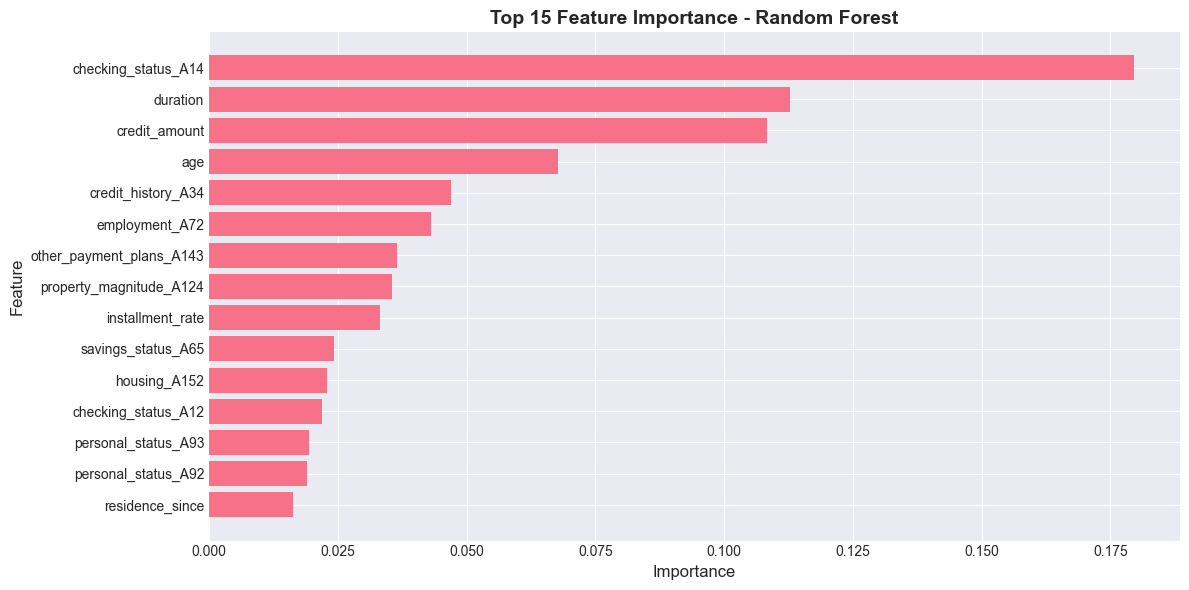

Top 15 Most Important Features (Random Forest):
                 feature  importance
     checking_status_A14    0.179526
                duration    0.112860
           credit_amount    0.108337
                     age    0.067746
      credit_history_A34    0.046864
          employment_A72    0.043085
other_payment_plans_A143    0.036398
 property_magnitude_A124    0.035418
        installment_rate    0.033089
      savings_status_A65    0.024165
            housing_A152    0.022975
     checking_status_A12    0.021832
     personal_status_A93    0.019339
     personal_status_A92    0.018971
         residence_since    0.016366


In [26]:
# Random Forest feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
plt.barh(range(len(feature_importance_rf)), feature_importance_rf['importance'])
plt.yticks(range(len(feature_importance_rf)), feature_importance_rf['feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 15 Most Important Features (Random Forest):")
print("=" * 50)
print(feature_importance_rf.to_string(index=False))

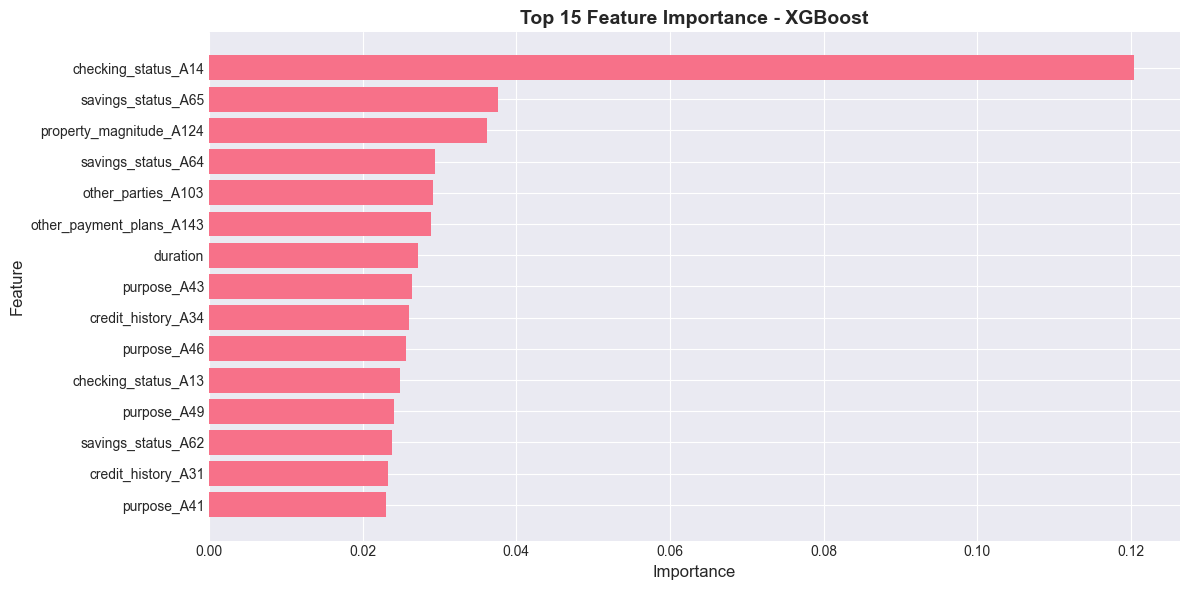

Top 15 Most Important Features (XGBoost):
                 feature  importance
     checking_status_A14    0.120402
      savings_status_A65    0.037664
 property_magnitude_A124    0.036124
      savings_status_A64    0.029376
      other_parties_A103    0.029175
other_payment_plans_A143    0.028869
                duration    0.027138
             purpose_A43    0.026452
      credit_history_A34    0.025969
             purpose_A46    0.025612
     checking_status_A13    0.024859
             purpose_A49    0.024121
      savings_status_A62    0.023865
      credit_history_A31    0.023279
             purpose_A41    0.022964


In [27]:
if XGBOOST_AVAILABLE:
    # XGBoost feature importance
    feature_importance_xgb = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(feature_importance_xgb)), feature_importance_xgb['importance'])
    plt.yticks(range(len(feature_importance_xgb)), feature_importance_xgb['feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Top 15 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 15 Most Important Features (XGBoost):")
    print("=" * 50)
    print(feature_importance_xgb.to_string(index=False))

## 8. Credit Score Generation

In [28]:
# Select best model (based on ROC-AUC)
best_model_name = results_df['ROC-AUC'].idxmax()
print(f"Best performing model: {best_model_name}")
print(f"ROC-AUC Score: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")

# Select the best model and its probabilities
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    best_proba = lr_test_proba
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_proba = rf_test_proba
else:
    best_model = xgb_model
    best_proba = xgb_test_proba

Best performing model: Logistic Regression
ROC-AUC Score: 0.8000


In [29]:
# Generate credit scores (300-850 scale, similar to FICO)
def probability_to_credit_score(prob, min_score=300, max_score=850):
    """
    Convert probability of default to credit score.
    Lower probability of default = Higher credit score
    """
    # Invert probability (1 - prob) so high prob of bad credit gives low score
    good_prob = 1 - prob
    score = min_score + (good_prob * (max_score - min_score))
    return np.round(score).astype(int)

# Calculate credit scores for test set
credit_scores = probability_to_credit_score(best_proba)

print(f"Credit Score Statistics:")
print("=" * 50)
print(f"Mean: {credit_scores.mean():.2f}")
print(f"Median: {np.median(credit_scores):.2f}")
print(f"Std Dev: {credit_scores.std():.2f}")
print(f"Min: {credit_scores.min()}")
print(f"Max: {credit_scores.max()}")

Credit Score Statistics:
Mean: 678.38
Median: 727.00
Std Dev: 142.30
Min: 349
Max: 847


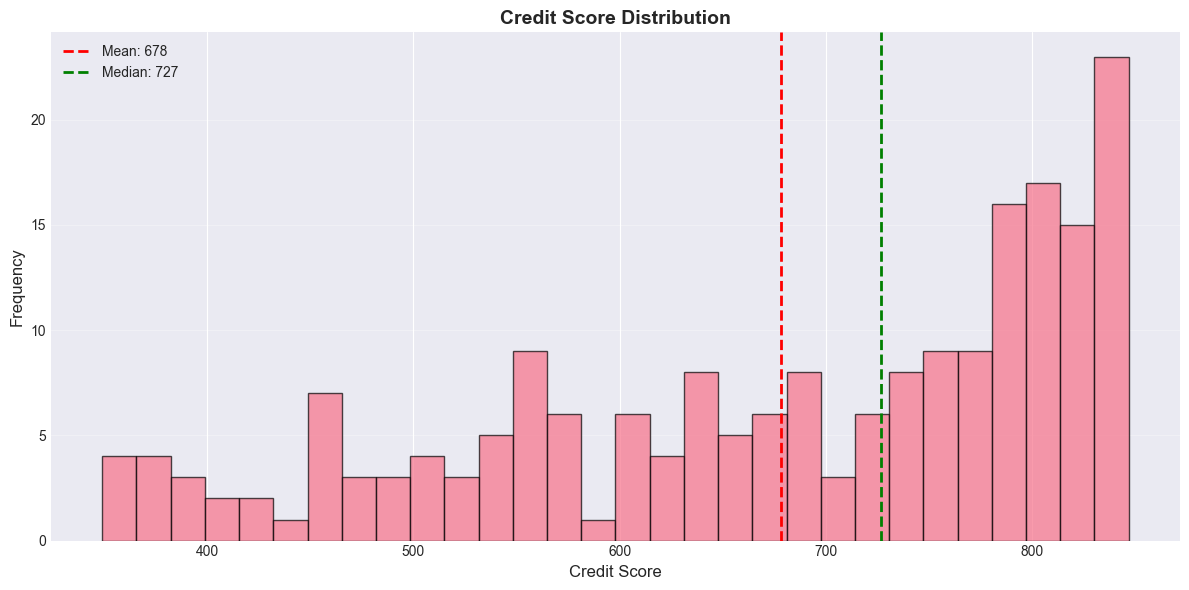

In [30]:
# Credit score distribution
plt.figure(figsize=(12, 6))
plt.hist(credit_scores, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(credit_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {credit_scores.mean():.0f}')
plt.axvline(np.median(credit_scores), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(credit_scores):.0f}')
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Credit Score Distribution', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [31]:
# Define risk categories
def categorize_risk(score):
    if score >= 740:
        return 'Excellent'
    elif score >= 670:
        return 'Good'
    elif score >= 580:
        return 'Fair'
    elif score >= 500:
        return 'Poor'
    else:
        return 'Very Poor'

risk_categories = [categorize_risk(score) for score in credit_scores]
risk_df = pd.DataFrame({
    'Risk Category': risk_categories
})

print("Risk Category Distribution:")
print("=" * 50)
print(risk_df['Risk Category'].value_counts().sort_index())

Risk Category Distribution:
Risk Category
Excellent    95
Fair         27
Good         22
Poor         27
Very Poor    29
Name: count, dtype: int64


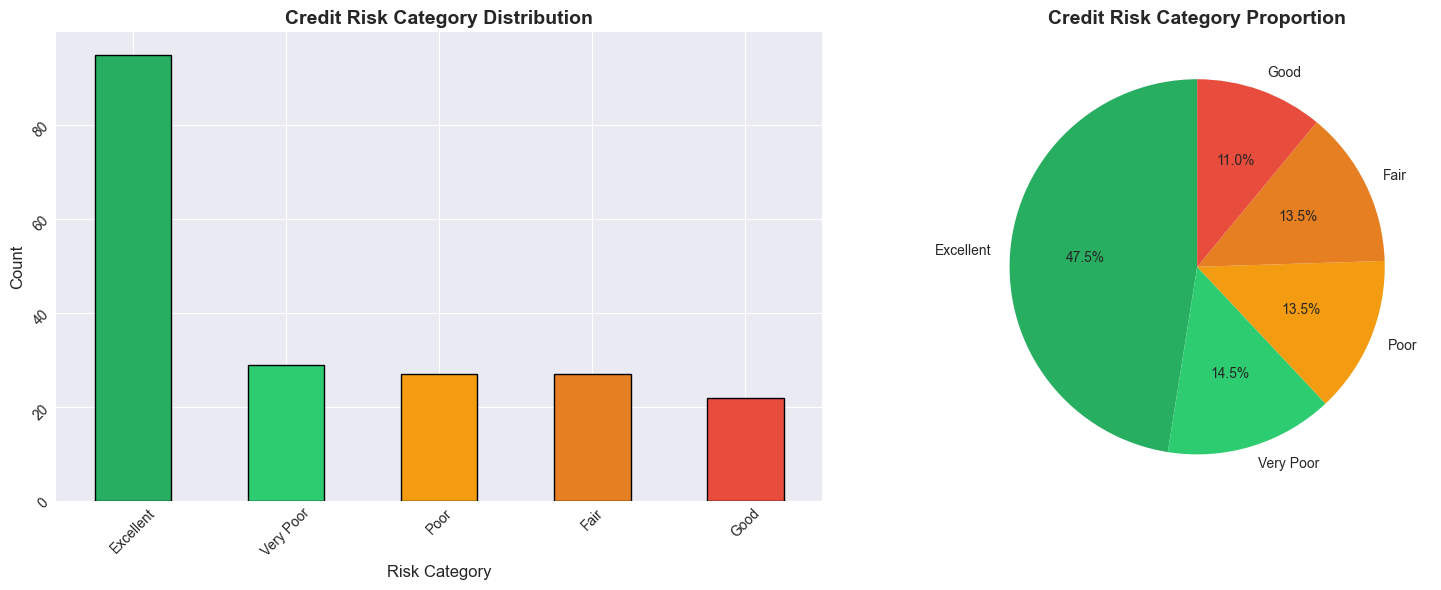

In [32]:
# Visualize risk categories
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
risk_counts = risk_df['Risk Category'].value_counts()
colors = ['#27ae60', '#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
risk_counts.plot(kind='bar', ax=ax[0], color=colors, edgecolor='black')
ax[0].set_title('Credit Risk Category Distribution', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Risk Category', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].tick_params(rotation=45)

# Pie chart
risk_counts.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=colors, startangle=90)
ax[1].set_title('Credit Risk Category Proportion', fontsize=14, fontweight='bold')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [33]:
# Create final results dataframe
results_test = pd.DataFrame({
    'Actual_Class': y_test.values,
    'Predicted_Class': best_model.predict(X_test_scaled if best_model_name == 'Logistic Regression' else X_test),
    'Default_Probability': best_proba,
    'Credit_Score': credit_scores,
    'Risk_Category': risk_categories
})

results_test['Actual_Label'] = results_test['Actual_Class'].map({0: 'Good', 1: 'Bad'})
results_test['Predicted_Label'] = results_test['Predicted_Class'].map({0: 'Good', 1: 'Bad'})

print("Sample Credit Scoring Results:")
print("=" * 100)
print(results_test[['Actual_Label', 'Predicted_Label', 'Default_Probability', 
                     'Credit_Score', 'Risk_Category']].head(20))

Sample Credit Scoring Results:
   Actual_Label Predicted_Label  Default_Probability  Credit_Score  \
0          Good            Good             0.196913           742   
1          Good            Good             0.093954           798   
2           Bad             Bad             0.631202           503   
3          Good            Good             0.498466           576   
4           Bad            Good             0.150909           767   
5          Good            Good             0.098844           796   
6          Good            Good             0.217161           731   
7          Good            Good             0.107626           791   
8          Good            Good             0.497623           576   
9          Good            Good             0.121808           783   
10         Good            Good             0.122779           782   
11          Bad             Bad             0.511202           569   
12         Good            Good             0.016195       

<Figure size 1000x600 with 0 Axes>

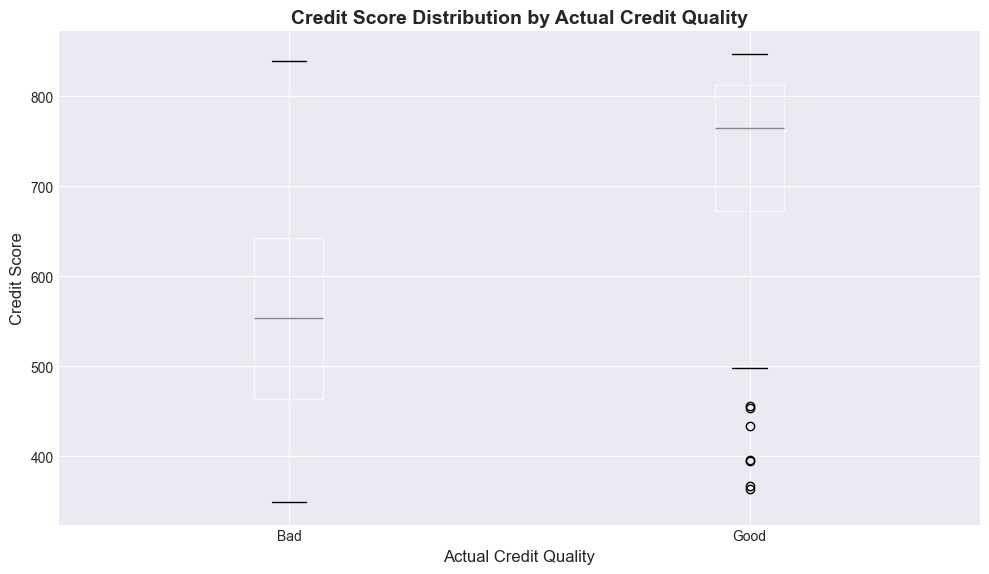

In [34]:
# Box plot of credit scores by actual class
plt.figure(figsize=(10, 6))
results_test.boxplot(column='Credit_Score', by='Actual_Label', figsize=(10, 6))
plt.title('Credit Score Distribution by Actual Credit Quality', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xlabel('Actual Credit Quality', fontsize=12)
plt.ylabel('Credit Score', fontsize=12)
plt.tight_layout()
plt.show()

## 9. Summary and Conclusions

In [35]:
print("="*80)
print("CREDIT SCORING MODEL - SUMMARY")
print("="*80)
print(f"\nDataset: German Credit Data")
print(f"Total Records: {len(df)}")
print(f"Features: {X.shape[1]} (after encoding)")
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {results_df.loc[best_model_name, 'Accuracy']:.4f}")
print(f"Test ROC-AUC: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")
print(f"Test F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"\nCredit Score Range: {credit_scores.min()} - {credit_scores.max()}")
print(f"Average Credit Score: {credit_scores.mean():.2f}")
print(f"\nRisk Category Breakdown:")
for category in ['Excellent', 'Good', 'Fair', 'Poor', 'Very Poor']:
    count = (risk_df['Risk Category'] == category).sum()
    pct = count / len(risk_df) * 100
    print(f"  {category:12s}: {count:3d} ({pct:5.1f}%)")
print("="*80)

print("\nKey Insights:")
print("-" * 80)
print("1. The model successfully predicts credit risk with good accuracy")
print("2. Credit scores range from 300-850, following standard scoring conventions")
print("3. Feature importance analysis reveals key risk factors")
print("4. The model can be used for credit decision-making and risk assessment")
print("="*80)

CREDIT SCORING MODEL - SUMMARY

Dataset: German Credit Data
Total Records: 1000
Features: 48 (after encoding)

Best Model: Logistic Regression
Test Accuracy: 0.7850
Test ROC-AUC: 0.8000
Test F1-Score: 0.6195

Credit Score Range: 349 - 847
Average Credit Score: 678.38

Risk Category Breakdown:
  Excellent   :  95 ( 47.5%)
  Good        :  22 ( 11.0%)
  Fair        :  27 ( 13.5%)
  Poor        :  27 ( 13.5%)
  Very Poor   :  29 ( 14.5%)

Key Insights:
--------------------------------------------------------------------------------
1. The model successfully predicts credit risk with good accuracy
2. Credit scores range from 300-850, following standard scoring conventions
3. Feature importance analysis reveals key risk factors
4. The model can be used for credit decision-making and risk assessment


## 10. Save Results

In [36]:
# Save results to CSV
results_test.to_csv('credit_scoring_results.csv', index=False)
print("Results saved to 'credit_scoring_results.csv'")

# Save model performance comparison
results_df.to_csv('model_comparison.csv')
print("Model comparison saved to 'model_comparison.csv'")

Results saved to 'credit_scoring_results.csv'
Model comparison saved to 'model_comparison.csv'
